In [1]:
import os
os.system('pip3 install -r requirements.txt')

0

In [2]:
# Importamos las librerias necesarias
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import matplotlib.dates as mdates


In [3]:
# Download historical data for SPY from Yahoo Finance
spy = yf.download('SPY', start='2010-01-01', end='2023-01-01')
print(spy)

# Split data into training (2010-2020) and validation (2020-2023) sets
training_data = spy['Adj Close']['2010-01-01':'2020-12-31']
validation_data = spy['Adj Close']['2021-01-01':'2023-01-01']

# Use 'Adj Close' prices as the stock price for training
training_set = training_data.values.reshape(-1, 1)
validation_set = validation_data.values.reshape(-1, 1)

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04  112.370003  113.389999  111.510002  113.330002   87.129936   
2010-01-05  113.260002  113.680000  112.849998  113.629997   87.360573   
2010-01-06  113.519997  113.989998  113.430000  113.709999   87.422066   
2010-01-07  113.500000  114.330002  113.180000  114.190002   87.791138   
2010-01-08  113.889999  114.620003  113.660004  114.570000   88.083267   
...                ...         ...         ...         ...         ...   
2022-12-23  379.649994  383.059998  378.029999  382.910004  377.177399   
2022-12-27  382.790009  383.149994  379.649994  381.399994  375.690033   
2022-12-28  381.329987  383.390015  376.420013  376.660004  371.020966   
2022-12-29  379.630005  384.350006  379.079987  383.440002  377.699463   
2022-12-30  380.640015  382.579987  378.429

In [4]:
# Feature scaling using MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
validation_set_scaled = sc.transform(validation_set)

In [5]:
# Creating input sequences for training
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(training_set_scaled)
X_validation, y_validation = create_sequences(validation_set_scaled)

# Reshape inputs for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))

In [6]:
# Building the LSTM Model
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units=1))

In [7]:
# Compiling the LSTM Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the Model and store history
history = model.fit(X_train, y_train, epochs=100, batch_size=2048, validation_data=(X_validation, y_validation))


Epoch 1/100

2/2 [==============================] - 8s 2s/step - loss: 0.2070 - val_loss: 0.9546
Epoch 2/100
2/2 [==============================] - 1s 523ms/step - loss: 0.1092 - val_loss: 0.4042
Epoch 3/100
2/2 [==============================] - 1s 524ms/step - loss: 0.0305 - val_loss: 0.0096
Epoch 4/100
2/2 [==============================] - 1s 528ms/step - loss: 0.0372 - val_loss: 0.0147
Epoch 5/100
2/2 [==============================] - 1s 615ms/step - loss: 0.0247 - val_loss: 0.1386
Epoch 6/100
2/2 [==============================] - 1s 539ms/step - loss: 0.0125 - val_loss: 0.2681
Epoch 7/100
2/2 [==============================] - 1s 557ms/step - loss: 0.0207 - val_loss: 0.2884
Epoch 8/100
2/2 [==============================] - 1s 533ms/step - loss: 0.0230 - val_loss: 0.2172
Epoch 9/100
2/2 [==============================] - 1s 507ms/step - loss: 0.0152 - val_loss: 0.1080
Epoch 10/100
2/2 [==============================] - 1s 486ms/step - loss: 0.0083 - val_loss: 0.0303
Epoch 11/1

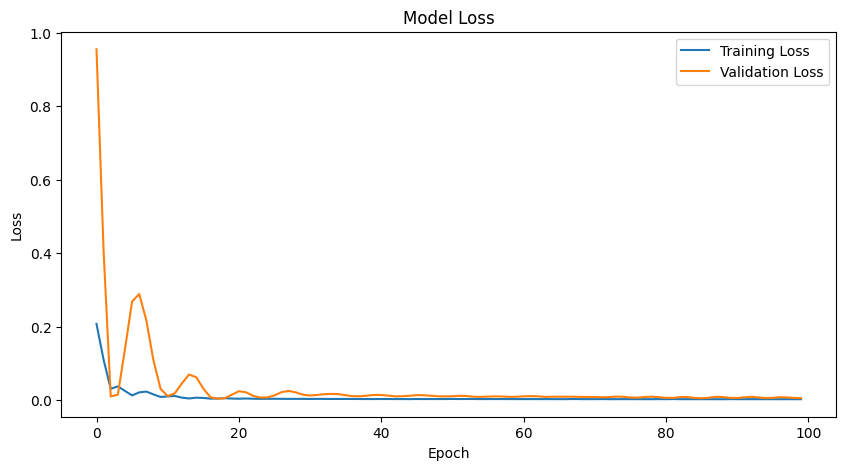

In [8]:
# Plot loss and accuracy during training
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Download test data for SPY from Yahoo Finance
spy_test = yf.download('SPY', start='2023-01-01', end='2023-07-31')

# Use 'Adj Close' prices as the test data
real_stock_price = spy_test['Adj Close'].values.reshape(-1, 1)

[*********************100%%**********************]  1 of 1 completed


In [10]:
# Preparing Test Data
dataset_total = pd.concat((spy['Adj Close'], spy_test['Adj Close']), axis=0)
inputs = dataset_total[len(dataset_total) - len(spy_test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [11]:
# Making Predictions
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

5/5 [==============================] - 1s 21ms/step


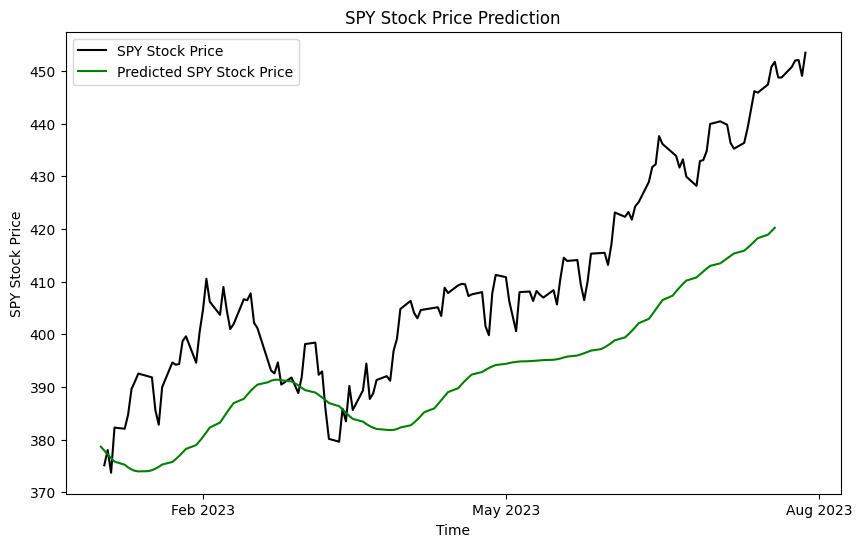

In [12]:
# Prepare dates for the predicted stock prices
date_range = pd.date_range(start='2023-01-01', periods=len(predicted_stock_price), freq='B')  # 'B' for business day frequency

# Visualizing Results with Month and Year on X-axis
plt.figure(figsize=(10, 6))
plt.plot(spy_test.index, real_stock_price, color='black', label='SPY Stock Price')
plt.plot(date_range, predicted_stock_price, color='green', label='Predicted SPY Stock Price')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show tick marks for every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.
plt.title('SPY Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SPY Stock Price')
plt.legend()
plt.show()